# PLOT WATER MASSES TRANSPORT

In [1]:
import numpy as N
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.colors as colors
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature

### read the grid 
####  restrcit it to the same bounds as data

In [2]:
#read grid
xi_bnds,eta_bnds=(420,1026),(350,860)
ds_grid=xr.open_dataset('/home/shom_simuref/CROCO/ODC/CONFIGS/MEDITERRANEE_GLOBALE/CROCO_FILES/test2.nc')
ds_grid=ds_grid.isel(xi_rho=slice(*xi_bnds), eta_rho=slice(*eta_bnds),
                      xi_u=slice(*xi_bnds),eta_v=slice(*eta_bnds))
mask=ds_grid.mask_rho.assign_coords({"X":ds_grid.lon_rho[0,:], "Y":ds_grid.lat_rho[:,0]})
mask=mask.swap_dims({"xi_rho":"X","eta_rho":"Y"})

In [3]:
waters=["naw","wiw","mdw","liw","maw","miw"]

out_path="//home/shom_simuref/CROCO/ODC/POSTPROC/MASSES_EAU/"


#### Select time range

In [37]:
date_start="2012-06-01"
date_end="2013-08-01"
time_range=slice(date_start,date_end)
print('time range',time_range)

time range slice('2012-06-01', '2013-08-01', None)


### function that read the data


In [38]:
def read_data(water):
 ds=xr.open_dataset(f'{out_path}/{water}.nc')
 vlist=list(ds.variables)
 vol=ds[vlist[-1]].rename(f'{water}_volume')
 transu=ds[vlist[-3]].rename(f'{water}_transu')
 transv=ds[vlist[-2]].rename(f'{water}_transv')
 #return data in Sverdrup (1e6 m3/s)
 vol/=1e6
 transu/=1e6
 transv/=1e6
 return transu,transv,vol

In [39]:
#transu,transv,vol=read_data(waters[1])

### General plot parameters


In [40]:
#set map projection
proj=ccrs.LambertConformal(central_latitude=38,central_longitude=15)
#projection of the data
src_proj=ccrs.PlateCarree()
#set colormap
cmap = plt.get_cmap('rainbow')
#get lon lat for the plots
lon=ds_grid.lon_rho
lat=ds_grid.lat_rho



### Function that plot the data

In [41]:
def plot_data(lon,lat,u,v,vol,ax,water):
    #get max data for quiverkey 
    maxdata=int(vol.max())
    #plot parameters
    levels=N.arange(0,maxdata,int(maxdata/15))
    norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    kwargs_plot=dict(norm=norm,transform=src_proj,cmap=cmap)

    #do the background plot with volume
    cf=ax.pcolormesh(lon,lat,vol.data,**kwargs_plot)
    
    #set extent 
    ax.set_extent([0,10,37,44],crs=ccrs.PlateCarree())
    
    #set coastline , land and grid labels
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
    gl.xlines=False
    gl.ylines=False
    gl.top_labels=False
    gl.right_labels=False

    #do quiver plot
    Q=ax.quiver(x=lon.data,y=lat.data,u=u.data,v=v.data,transform=src_proj,regrid_shape=40)
    mean_trans=N.ma.sqrt(u**2+v**2)
    mtrans=mean_trans.max().round(2)
    qk=ax.quiverkey(Q,0.2,0.8,mtrans,f"{mtrans} Sv",labelpos="N")
   
    #set colorbar
    cax,kw = matplotlib.colorbar.make_axes(ax,location='right',shrink=0.9)
    col=fig.colorbar(cf,cax=cax,extend='both',**kw)
    col.ax.set_title('1$e^6$ $m^3$',fontsize=8)

    #set title
    ax.set_title(f'{water} water')
    return ax,cf

### function to get some stats about transport

In [42]:
def stat(d1,d2):
    mod=N.sqrt(d1**2+d2**2)
    mint=mod.min().data
    maxt=mod.max().data
    meant=mod.mean().data
    print(f'Max transport {maxt:.3f} in Sv')
    print(f'Mean transport {meant:.3f} in Sv')


### Do the plots with a loop on waters 

naw
Max transport 0.025 in Sv
Mean transport 0.003 in Sv
wiw
Max transport 0.014 in Sv
Mean transport 0.002 in Sv
mdw
Max transport 0.727 in Sv
Mean transport 0.064 in Sv
liw
Max transport 0.075 in Sv
Mean transport 0.008 in Sv
maw
Max transport 0.167 in Sv
Mean transport 0.017 in Sv
miw
Max transport 0.118 in Sv
Mean transport 0.014 in Sv


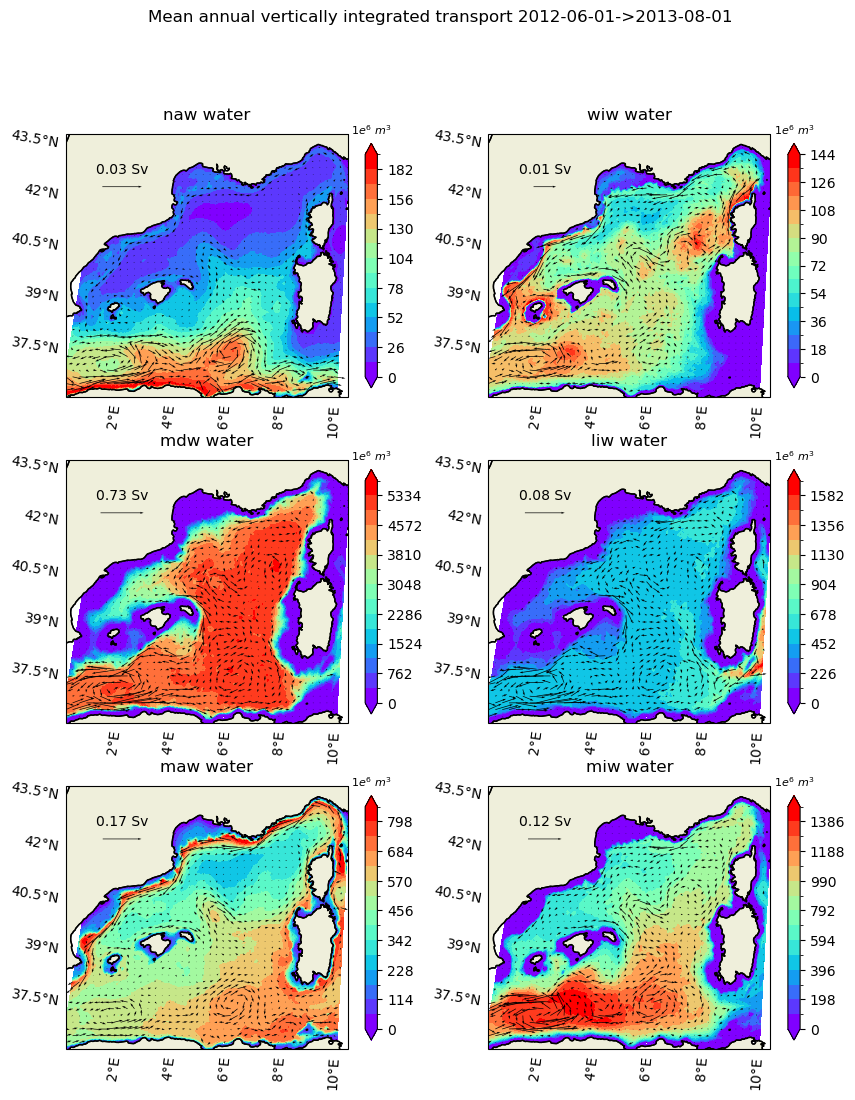

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12),subplot_kw=dict(projection=proj))
for i, water in enumerate(waters):
    print(water)
    transu,transv,vol=read_data(water)
    transu=transu.sel(time=time_range)
    transv=transv.sel(time=time_range)
    vol=vol.sel(time=time_range)
 
    mtransu=transu.mean("time")
    mtransv=transv.mean("time")
    mvol=vol.mean("time")
    
    stat(mtransu,mtransv)
    ax,cf=plot_data(lon,lat,mtransu,mtransv,mvol,axes.flatten()[i],water)

plt.suptitle(f'Mean annual vertically integrated transport {date_start}->{date_end}')

plt.savefig('water_masses_transport.png')

## DEBUG AND TESTS

<xarray.DataArray 'maw_transu' ()>
array(-0.15901654) <xarray.DataArray 'maw_transu' ()>
array(0.06156553)


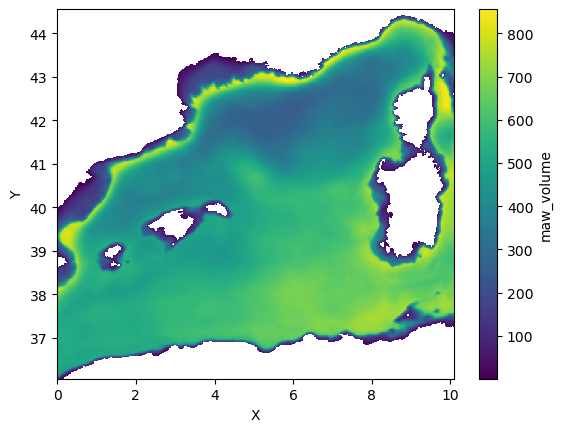

In [44]:
water=waters[4]
transu,transv,vol=read_data(water)
mean_transu=transu.mean("time")
mean_transu=mean_transu.where(mask)
mean_transv=transv.mean("time")
mean_transv=mean_transv.where(mask)
mean_vol=vol.mean("time").where(mask)
mean_vol.plot()
print(mean_transu.min(),mean_transu.max())

Text(0.5, 1.0, 'maw water')

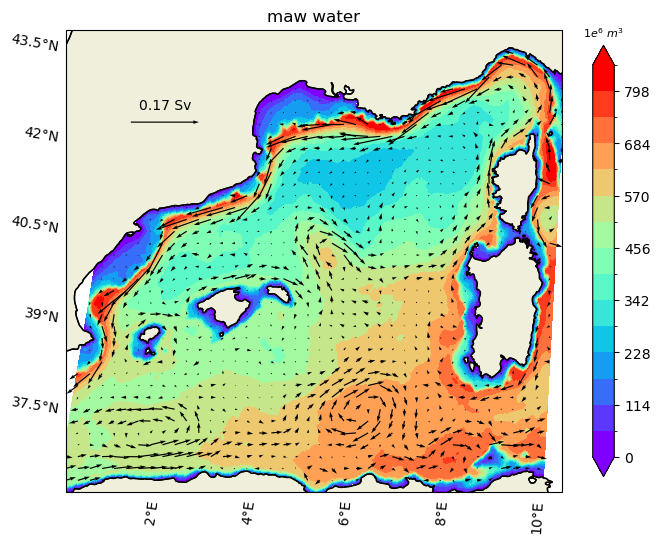

In [45]:
#set the figure
fig,ax=plt.subplots(1,1,figsize=(8,8),subplot_kw=dict(projection=proj))

#set data
data=mean_vol
maxdata=int(mean_vol.max())
#plot parameters
levels=N.arange(0,maxdata,int(maxdata/15))
norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
kwargs_plot=dict(norm=norm,transform=src_proj,cmap=cmap)

#do the background plot with volume
cf=ax.pcolormesh(lon,lat,data,**kwargs_plot)
#set extent 
ax.set_extent([0,10,37,44],crs=src_proj)
#set coastline and land
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
gl.xlines=False
gl.ylines=False
gl.top_labels=False
gl.right_labels=False

#do quiver plot
Q=ax.quiver(x=lon.data,y=lat.data,u=mean_transu.data,v=mean_transv.data,transform=src_proj,regrid_shape=40)
mean_trans=N.ma.sqrt(mean_transu**2+mean_transv**2)
mtrans=mean_trans.max().round(2)
qk=ax.quiverkey(Q,0.2,0.8,mtrans,f"{mtrans} Sv",labelpos="N")
#set colorbar
cax,kw = matplotlib.colorbar.make_axes(ax,location='right',shrink=0.7)
col=fig.colorbar(cf,cax=cax,extend='both',**kw)
col.ax.set_title('1$e^6$ $m^3$',fontsize=8)
#set title
ax.set_title(f'{water} water')
